# Using link function for more generalized models

In [113]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

## Visualizing the data  

Visualizing the data can help us predict model parameters.

In [114]:
data = pd.read_csv("./Airline_data.csv")

In [115]:
data.head(5)

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
0,1976,24,734,3863.0
1,1977,25,516,4300.0
2,1978,31,754,5027.0
3,1979,31,877,5481.0
4,1980,22,814,5814.0


In [116]:
data.describe()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
count,10.00000,10.000000,10.000000,10.000000
mean,1980.50000,23.800000,691.900000,5715.800000
std,3.02765,4.709329,252.389228,1117.767795
min,1976.00000,16.000000,223.000000,3863.000000
25%,1978.25000,21.250000,570.500000,5140.500000
50%,1980.50000,23.000000,759.000000,5845.500000
75%,1982.75000,25.750000,812.750000,6175.500000
max,1985.00000,31.000000,1066.000000,7433.000000


In [117]:
years = data["Year"][:]
accidents = data["Fatal accidents"][:]
deaths = data["Passenger deaths"][:]
miles_flown = data["Miles flown [100 mln miles]"][:]

In [118]:
years.head(5) # to check if the data was extracted correctly

0    1976
1    1977
2    1978
3    1979
4    1980
Name: Year, dtype: int64

In [119]:
accidents.describe()

count    10.000000
mean     23.800000
std       4.709329
min      16.000000
25%      21.250000
50%      23.000000
75%      25.750000
max      31.000000
Name: Fatal accidents, dtype: float64

In [120]:
miles_flown.describe()

count      10.000000
mean     5715.800000
std      1117.767795
min      3863.000000
25%      5140.500000
50%      5845.500000
75%      6175.500000
max      7433.000000
Name: Miles flown [100 mln miles], dtype: float64

Because those values for "miles_flown" are in the order of 10e12 (100 mln * 1e3), it would be helpful to use 10e12 as our unit. This way, the values will be easier to work with.

In [121]:
miles_flown_scaled = miles_flown.rename("Miles flown [10e12]", inplace=False)
miles_flown_scaled = miles_flown_scaled / 1000.0
miles_flown_scaled.describe()

count    10.000000
mean      5.715800
std       1.117768
min       3.863000
25%       5.140500
50%       5.845500
75%       6.175500
max       7.433000
Name: Miles flown [10e12], dtype: float64

This range of values will be much more comfortable to work with.  

Also, centering the data around the mean value can help with model robustness, so let's create a data series that's centered.

In [122]:
miles_flown_scaled_centered = miles_flown_scaled.rename("Miles flown centered", inplace=False)
miles_flown_scaled_centered = miles_flown_scaled_centered - miles_flown_scaled_centered.mean()
miles_flown_scaled_centered.describe()

count    1.000000e+01
mean     1.776357e-16
std      1.117768e+00
min     -1.852800e+00
25%     -5.753000e-01
50%      1.297000e-01
75%      4.597000e-01
max      1.717200e+00
Name: Miles flown centered, dtype: float64

Lets note that mean for this data is ~0, std ~1 (for later ppc).

## Proposed model

$$ y_i\sim\mathrm{Poisson}(\underbrace{\exp(\alpha+\theta (n_i-n_{mean}))}_{\lambda_i})$$  
$$\log \lambda_i=\alpha+\theta (n_i-n_{mean})$$

Where $n_i$ the ammount of miles flown the year. We're trying to predict $y_i$ - number of accidents.

Since we're working with log scale, the range for $n$ parameter must be chosen carefully.

$ y_i\sim\mathrm{Poisson}(\lambda_i)$  
$\log \lambda_i=\alpha+\theta (n_i-n_{mean})$  
$bounds_{low} < \log \lambda_i < bounds_{high}$  
$bounds_{low} < \alpha+\theta (n_i-n_{mean}) < bounds_{high}$  

So this comes down to solving a linear equation.

In [123]:
# from data visualization we know the range of n (miles flown) and the rough output range 

bounds = (10, 40) # min/max from dataset if 16/31, so let's round down/up for ppc model parameters

# n - miles centered
n_max = miles_flown_scaled_centered.max()
n_min = miles_flown_scaled_centered.min()

theta = (np.log(bounds[1]) - np.log(bounds[0])) / (n_max - n_min) # slope
alpha = np.log(bounds[0]) - theta * n_min # intercept

print(f"theta: {theta}\nalpha: {alpha}")

theta: 0.3883177482128545
alpha: 3.0220602168828226


### Prior predictive checks

In [124]:
%%writefile ppc/airline_1_ppc.stan

generated quantities {
    real alpha = normal_rng(3, 3.0 / 3.0); // using 30% of the value as std
    real theta = normal_rng(0.4, 0.4 / 3.0); // as above
    real n = normal_rng(0, 1); // from centered, scaled data - see the note a couple of cells above
    real l = exp(alpha + theta * n); // lambda_i
    real accidents = poisson_rng(l);
}

Overwriting ppc/airline_1_ppc.stan


In [125]:
airline_1_ppc_model = CmdStanModel(stan_file="./ppc/airline_1_ppc.stan")

INFO:cmdstanpy:compiling stan file /home/labs/DataAnalytics2023/Lab5/ppc/airline_1_ppc.stan to exe file /home/labs/DataAnalytics2023/Lab5/ppc/airline_1_ppc


INFO:cmdstanpy:compiled model executable: /home/labs/DataAnalytics2023/Lab5/ppc/airline_1_ppc


In [126]:
R = 1000
ppc_sim = airline_1_ppc_model.sample(iter_sampling=R,
                                     iter_warmup=0,
                                     chains=1,
                                     fixed_param=True,
                                     seed=12072023,
                                     refresh=R)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [127]:
ppc_df = ppc_sim.draws_pd()
ppc_df.describe()

,lp__,accept_stat__,alpha,theta,n,l,accidents
count,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.0,0.0,3.007112,0.398625,-0.030053,37.603141,37.465000
std,0.0,0.0,1.018550,0.139880,1.022713,51.397598,51.584258
min,0.0,0.0,-0.291135,-0.040258,-3.764440,0.790769,0.000000
25%,0.0,0.0,2.344230,0.308451,-0.713321,9.330815,9.000000
50%,0.0,0.0,3.004635,0.396056,-0.030398,20.091650,19.000000
75%,0.0,0.0,3.692943,0.488843,0.646473,44.608225,43.000000
max,0.0,0.0,6.035960,0.786661,3.052620,416.137000,423.000000


In [128]:
ppc_df.head(5)

,lp__,accept_stat__,alpha,theta,n,l,accidents
0,0.0,0.0,1.11737,0.470196,-0.579286,2.32797,1.0
1,0.0,0.0,2.61965,0.448383,-1.735230,6.30662,4.0
2,0.0,0.0,3.45448,0.720615,-1.313300,12.28150,9.0
3,0.0,0.0,2.98894,0.134757,-0.196647,19.34520,29.0
4,0.0,0.0,3.15216,0.563000,1.433610,52.41990,65.0


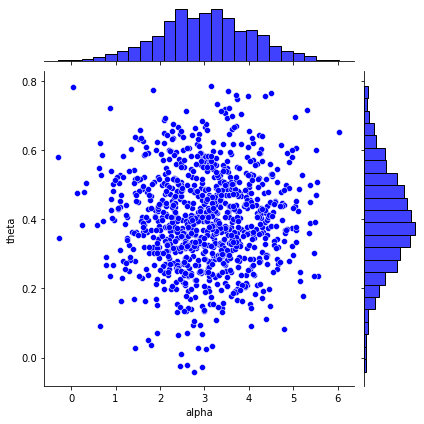

In [129]:
sns.jointplot(data=ppc_df, x='alpha', y='theta', color='b')
plt.show()

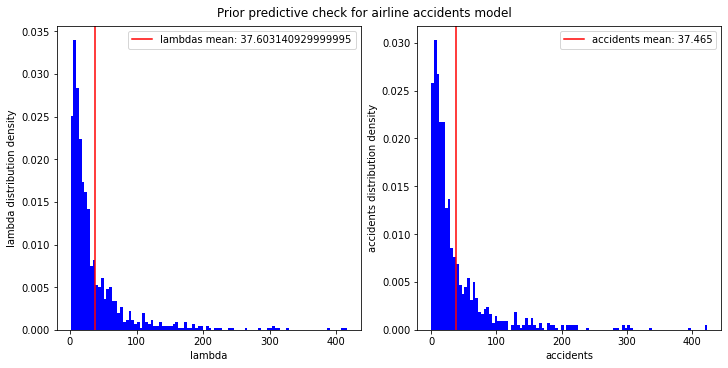

In [130]:
ppc_lambdas = ppc_df["l"].values
ppc_accidents = ppc_df["accidents"].values

fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

fig.suptitle("Prior predictive check for airline accidents model")

ax[0].hist(ppc_lambdas, density=True, color='b', bins=100)
ax[0].axvline(x=ppc_lambdas.mean(), color='r', label=f"lambdas mean: {ppc_lambdas.mean()}")
ax[0].set_xlabel("lambda")
ax[0].set_ylabel("lambda distribution density")
ax[0].legend()

ax[1].hist(ppc_accidents, density=True, color='b', bins=100)
ax[1].axvline(x=ppc_accidents.mean(), color='r', label=f"accidents mean: {ppc_accidents.mean()}")
ax[1].set_xlabel("accidents")
ax[1].set_ylabel("accidents distribution density")
ax[1].legend()

plt.show()

## Model definition

In [131]:
%%writefile model/airline_1_fit.stan

data {
    int<lower=0> N;
    vector[N] miles;
    int accidents[N]; // specify the vector is of int type
}

parameters {
    real alpha;
    real theta;
}

transformed parameters {
    real lambdas[N];
    for (i in 1:N) {
        lambdas[i] = exp(alpha + theta * miles[i]);
    }
}

model {
    alpha ~ normal(3, 3.0 / 3.0);
    theta ~ normal(0.4, 0.4 / 3.0);
    for (i in 1:N) {
        accidents[i] ~ poisson(lambdas[i]);
    }
}

Overwriting model/airline_1_fit.stan


In [132]:
airline_1_fit_model = CmdStanModel(stan_file="model/airline_1_fit.stan")

INFO:cmdstanpy:compiling stan file /home/labs/DataAnalytics2023/Lab5/model/airline_1_fit.stan to exe file /home/labs/DataAnalytics2023/Lab5/model/airline_1_fit


INFO:cmdstanpy:compiled model executable: /home/labs/DataAnalytics2023/Lab5/model/airline_1_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/labs/DataAnalytics2023/Lab5/model/airline_1_fit.hpp /home/labs/DataAnalytics2023/Lab5/model/airline_1_fit.stan
Warning in '/home/labs/DataAnalytics2023/Lab5/model/airline_1_fit.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/labs/DataAnalytics2023/Lab5/model/airline_1_fit.stan', line 14, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y 

In [133]:
fit_data = {'N': 10, 'miles': miles_flown_scaled_centered.values, 'accidents': accidents.values}

In [134]:
airline_fit = airline_1_fit_model.sample(data=fit_data,
                                         seed=12072023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


In [135]:
fit_df = airline_fit.draws_pd()
fit_df.describe()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,theta,lambdas[1],lambdas[2],lambdas[3],lambdas[4],lambdas[5],lambdas[6],lambdas[7],lambdas[8],lambdas[9],lambdas[10]
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,510.900892,0.920259,0.856433,1.963250,3.788500,0.0,-509.909410,3.165823,-0.014639,24.534818,24.326922,24.015653,23.842600,23.725852,23.653699,23.704722,23.594047,23.277074,23.351903
std,1.006686,0.101704,0.071776,0.604145,1.906352,0.0,1.414975,0.065719,0.055097,2.934487,2.440315,1.795957,1.585714,1.565556,1.616715,1.575231,1.698209,2.707687,2.382377
min,503.161000,0.227185,0.757413,1.000000,1.000000,0.0,-511.888000,2.887830,-0.203939,16.306300,17.188500,18.382400,18.170400,17.864700,17.666500,17.807500,17.496300,15.234100,16.246600
25%,510.512500,0.880892,0.803318,2.000000,3.000000,0.0,-510.959250,3.122860,-0.051313,22.539225,22.658550,22.840225,22.797400,22.661175,22.541725,22.626675,22.435775,21.411575,21.709050
50%,511.221500,0.960025,0.870918,2.000000,3.000000,0.0,-510.244000,3.166205,-0.015380,24.448750,24.240150,23.925850,23.778800,23.693700,23.634600,23.677150,23.575650,23.174600,23.284300
75%,511.624250,0.996128,0.924034,2.000000,3.000000,0.0,-509.221750,3.209950,0.022675,26.433800,25.898050,25.230000,24.902175,24.746250,24.701400,24.728875,24.709250,25.024925,24.892100
max,511.905000,1.000000,0.926482,3.000000,7.000000,0.0,-500.278000,3.417700,0.164376,37.837000,34.610800,31.176200,30.205000,30.623200,30.901400,30.703000,31.144700,33.089800,32.302500


In [136]:
fit_df.head(5)

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,theta,lambdas[1],lambdas[2],lambdas[3],lambdas[4],lambdas[5],lambdas[6],lambdas[7],lambdas[8],lambdas[9],lambdas[10]
0,511.590,0.983340,0.818619,2.0,3.0,0.0,-511.402,3.12465,-0.038645,24.4407,24.0314,23.3657,22.9593,22.6657,22.4747,22.6106,22.3103,21.2910,21.5610
1,511.060,0.948303,0.818619,2.0,3.0,0.0,-510.799,3.16981,-0.086687,27.9502,26.9112,25.2675,24.2924,23.6012,23.1574,23.4727,22.7791,20.5108,21.0987
2,511.543,0.749376,0.818619,2.0,3.0,0.0,-507.932,3.13914,-0.055393,25.5789,24.9672,23.9817,23.3861,22.9587,22.6819,22.8787,22.4444,20.9893,21.3718
3,511.272,0.962969,0.818619,2.0,3.0,0.0,-510.940,3.21507,-0.061254,27.8981,27.1612,25.9782,25.2657,24.7556,24.4257,24.6603,24.1431,22.4184,22.8705
4,511.314,0.981254,0.818619,3.0,7.0,0.0,-510.560,3.09776,-0.019385,22.9582,22.7645,22.4460,22.2493,22.1061,22.0125,22.0791,21.9315,21.4231,21.5589


In [137]:
fit_lambdas = fit_df.loc[:, "lambdas[1]":"lambdas[10]"]

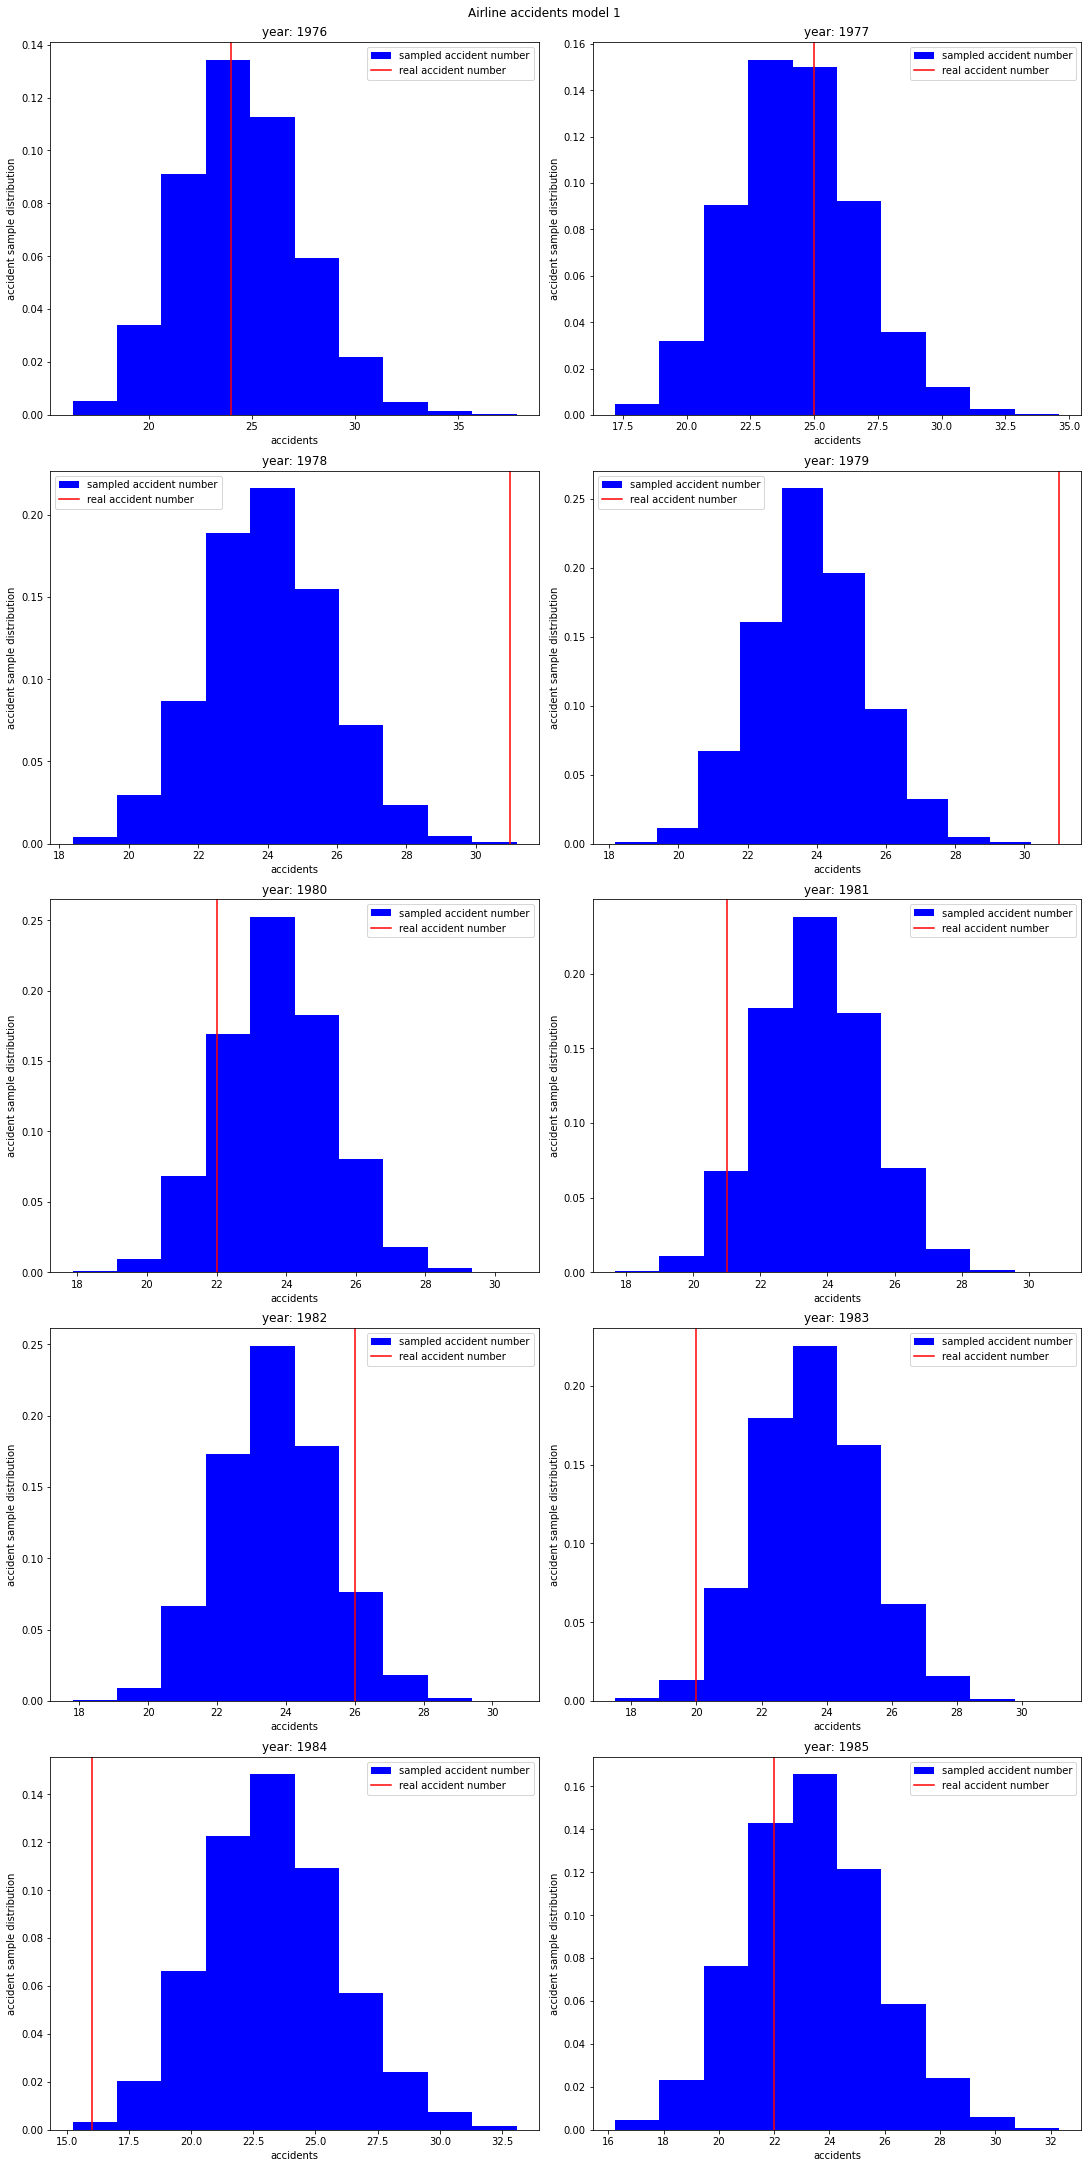

In [138]:
fig, ax = plt.subplots(int(len(years)/2), 2, figsize=(15, 30), constrained_layout=True)
ax = ax.flatten()

for i, axis in enumerate(ax):
    axis.hist(fit_lambdas[f"lambdas[{i+1}]"].values, density=True, color='b', label='sampled accident number')
    axis.axvline(x=accidents[i], color='r', label='real accident number')
    axis.set_xlabel('accidents')
    axis.set_ylabel('accident sample distribution')
    axis.set_title(f'year: {years[i]}')
    axis.legend()
fig.suptitle("Airline accidents model 1")
plt.show()

Fair to say those results are not very impressive. They do indicate however, that the model was fitted successfully, as the real values are in the realm of predictions. The distribution of the predictions leaves a lot to wish though.

## Model with separate $\alpha_i$ for each year

We'll use the same priors that we've used in the model with single alpha for all years.

### Posterior predictive checks

In [139]:
%%writefile model/airline_2_fit.stan

data {
    int<lower=0> N;
    vector[N] miles;
    int accidents[N]; // specify the vector is of int type
}

parameters {
    real alpha[N];
    real theta;
}

transformed parameters {
    real lambdas[N];
    for (i in 1:N) {
        lambdas[i] = exp(alpha[i] + theta * miles[i]);
    }
}

model {
    alpha ~ normal(3, 3.0 / 3.0);
    theta ~ normal(0.4, 0.4 / 3.0);
    for (i in 1:N) {
        accidents[i] ~ poisson(lambdas[i]);
    }
}

Overwriting model/airline_2_fit.stan


In [140]:
airline_2_fit_model = CmdStanModel(stan_file="model/airline_2_fit.stan")

INFO:cmdstanpy:compiling stan file /home/labs/DataAnalytics2023/Lab5/model/airline_2_fit.stan to exe file /home/labs/DataAnalytics2023/Lab5/model/airline_2_fit


INFO:cmdstanpy:compiled model executable: /home/labs/DataAnalytics2023/Lab5/model/airline_2_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/labs/DataAnalytics2023/Lab5/model/airline_2_fit.hpp /home/labs/DataAnalytics2023/Lab5/model/airline_2_fit.stan
Warning in '/home/labs/DataAnalytics2023/Lab5/model/airline_2_fit.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/labs/DataAnalytics2023/Lab5/model/airline_2_fit.stan', line 9, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/labs/DataAnalytics2023/Lab5/model/a

In [141]:
airline_fit = airline_2_fit_model.sample(data=fit_data,
                                         seed=12072023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


In [142]:
fit_df = airline_fit.draws_pd()
fit_df.describe()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha[1],alpha[2],alpha[3],...,lambdas[1],lambdas[2],lambdas[3],lambdas[4],lambdas[5],lambdas[6],lambdas[7],lambdas[8],lambdas[9],lambdas[10]
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,513.568088,0.909515,0.412596,3.119250,9.678000,0.0,-508.003823,3.730020,3.633467,3.623425,...,23.339240,24.403051,30.472294,30.472241,22.000416,21.150155,25.694079,20.134864,16.701810,22.398381
std,2.349708,0.098054,0.020356,0.354346,4.098843,0.0,3.305586,0.302997,0.263413,0.199479,...,4.710593,4.875814,5.562338,5.454795,4.571716,4.513736,5.062428,4.356778,4.005664,4.649686
min,502.124000,0.302458,0.380937,2.000000,3.000000,0.0,-515.915000,2.565290,2.754530,2.814600,...,8.720350,10.885900,15.471400,13.813700,8.480520,9.740320,12.014400,7.308730,6.243000,8.973030
25%,512.161750,0.866497,0.404027,3.000000,7.000000,0.0,-510.422500,3.523367,3.457650,3.490162,...,19.974300,20.917950,26.460575,26.616225,18.818900,17.917475,22.171725,16.986125,13.871550,19.146300
50%,513.873000,0.942090,0.416341,3.000000,7.000000,0.0,-508.292500,3.733270,3.639515,3.623715,...,23.155300,24.122900,29.993100,30.101850,21.712200,20.863450,25.332000,19.885200,16.404800,22.102950
75%,515.297250,0.983103,0.424910,3.000000,15.000000,0.0,-505.999000,3.935437,3.813978,3.760817,...,26.321525,27.438975,33.961475,33.943075,24.808625,24.015800,28.778475,22.932875,19.143825,25.367925
max,518.643000,1.000000,0.436765,5.000000,47.000000,0.0,-492.362000,4.754510,4.634490,4.271820,...,42.811600,44.534400,52.889100,55.491800,41.658500,40.011400,45.757000,36.785900,33.445700,42.116200


In [143]:
fit_df.head(5)

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha[1],alpha[2],alpha[3],...,lambdas[1],lambdas[2],lambdas[3],lambdas[4],lambdas[5],lambdas[6],lambdas[7],lambdas[8],lambdas[9],lambdas[10]
0,515.660,0.927507,0.411724,3.0,7.0,0.0,-510.773,3.70016,3.55377,3.90352,...,22.4929,22.3147,39.8576,28.9609,22.2969,24.5853,23.5376,25.6860,23.1479,22.5761
1,515.839,0.937607,0.411724,3.0,7.0,0.0,-511.509,3.81239,3.45278,3.73004,...,29.4517,22.7480,35.5280,25.8731,26.8418,24.7748,24.1668,17.2135,14.6762,18.8805
2,516.077,0.935158,0.411724,3.0,15.0,0.0,-510.464,3.84359,3.72747,3.56465,...,23.5802,24.6659,27.4033,38.6331,24.7310,14.5436,25.0533,16.7279,16.2463,23.0085
3,516.013,0.833155,0.411724,3.0,7.0,0.0,-507.591,3.86355,3.64651,3.45061,...,23.1188,22.0676,24.0916,34.7099,25.1054,15.5248,24.4514,21.2511,16.5165,17.6793
4,513.841,0.938824,0.411724,3.0,7.0,0.0,-510.962,3.99290,3.70754,3.94874,...,26.6066,23.6571,39.8111,29.6149,19.4047,28.7329,20.7695,21.1528,11.4222,27.4475


In [144]:
fit_lambdas = fit_df.loc[:, "lambdas[1]":"lambdas[10]"]

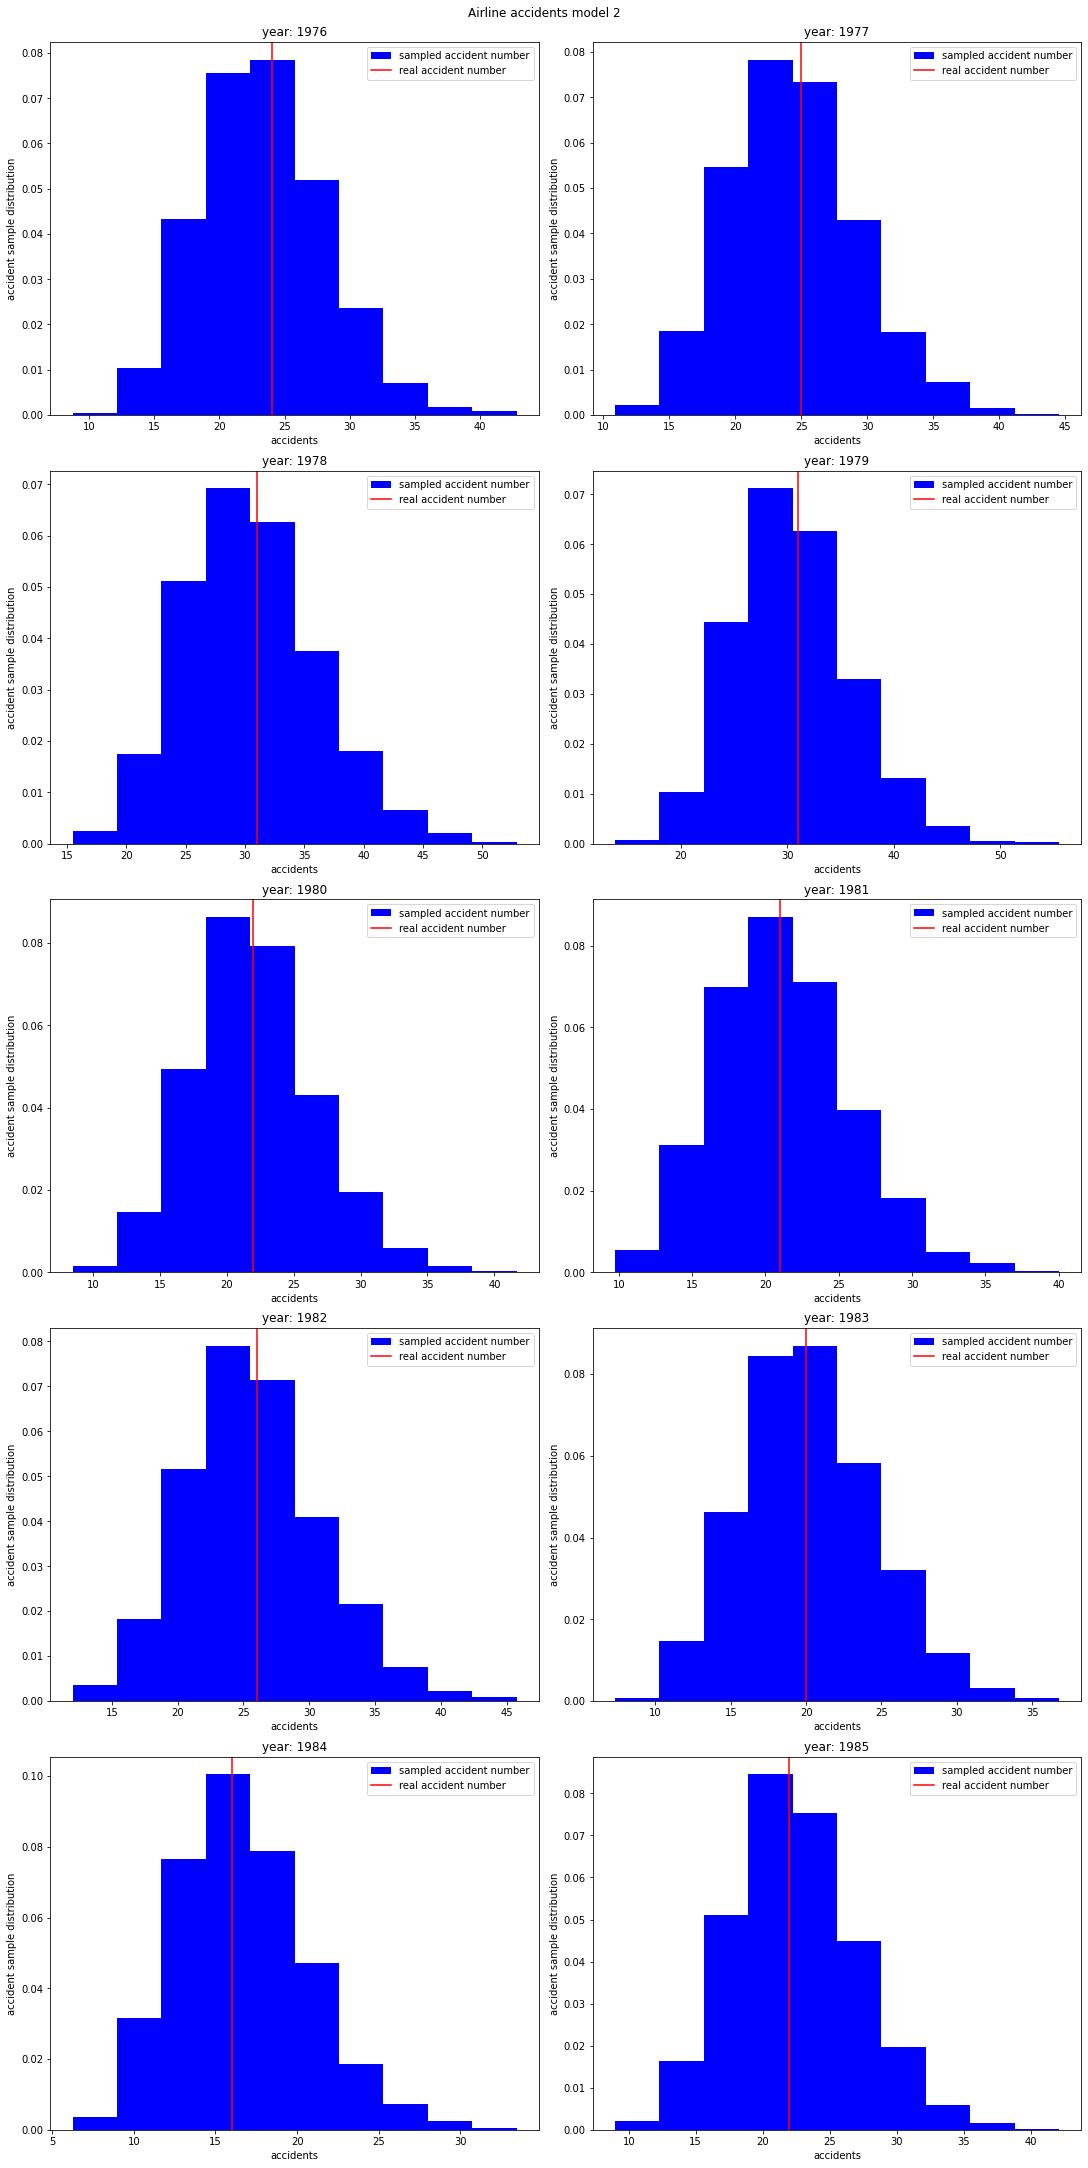

In [145]:
fig, ax = plt.subplots(int(len(years)/2), 2, figsize=(15, 30), constrained_layout=True)
ax = ax.flatten()

for i, axis in enumerate(ax):
    axis.hist(fit_lambdas[f"lambdas[{i+1}]"].values, density=True, color='b', label='sampled accident number')
    axis.axvline(x=accidents[i], color='r', label='real accident number')
    axis.set_xlabel('accidents')
    axis.set_ylabel('accident sample distribution')
    axis.set_title(f'year: {years[i]}')
    axis.legend()
fig.suptitle("Airline accidents model 2")
plt.show()

This model fits way better, which can be directly correlated with making the alpha parameter separate for each year. It does make intuitive sense, as there is no reason why the ammount of accidents _shouldn't_ vary over a couple of years. This is what we observe.  

The predictions are consistant with observed data for each year, as the model can fit better to the miles flown parameter. This makes intuitive sense, as the more miles are flown, the more the machines depreciate and the more failures (and human errors) can happen.

I would say this is a successful model for predicting this phenomenon.